# Analysis Insights

In [ ]:
# Import Packages

#!pip install imblearn
#!pip install xgboost
#!pip install lightgbm
#!pip install geopandas

# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#used to check the time elapsed since running
from time import time

# Measure runtime
import time

# Import warnings to remove flags when project is complete
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', 100)

# Import modelling-related libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline as skpipe
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb 
import lightgbm as lgbm 

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as imbpipe

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import plot_roc_curve, roc_auc_score, plot_confusion_matrix 
from sklearn.metrics import precision_recall_fscore_support as score

import geopandas

In [ ]:
# Import dataset

combined_df = pd.read_csv("datasets/combined_df_for_model.csv")

## Model Evaluation

In [ ]:
# Modelling preprocessing

features = [col for col in combined_df if col != 'wnvpresent']
X = combined_df[features]
y = combined_df['wnvpresent']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 42,
                                                    stratify = y)

numeric_features = ['block', 'latitude', 'longitude',
                           'addressaccuracy', 'tavg',
                           'dewpoint', 'wetbulb', 'preciptotal',
                           'stnpressure', 'sealevel', 'resultspeed',
                           'resultdir', 'avgspeed', 'year',
                           'month', 'day']

X_train_numeric = X_train[numeric_features]
X_test_numeric = X_test[numeric_features]

X_train_categorical = X_train.drop(columns=numeric_features, axis=1)
X_test_categorical = X_test.drop(columns=numeric_features, axis=1)

scaler = StandardScaler()
X_train_numeric = scaler.fit_transform( X_train_numeric )
X_test_numeric = scaler.transform( X_test_numeric )

X_train_numeric = pd.DataFrame(X_train_numeric, columns=numeric_features)
X_test_numeric = pd.DataFrame(X_test_numeric, columns=numeric_features)

X_train_total = pd.concat([X_train_numeric.reset_index(drop=True), X_train_categorical.reset_index(drop=True)], axis=1)
X_test_total = pd.concat([X_test_numeric.reset_index(drop=True), X_test_categorical.reset_index(drop=True)], axis=1)


In [ ]:
# Best Model with Confusion Metric Function

# Confusion Metric

resamplers = {'smote': SMOTE(random_state=42),
              'adasyn': ADASYN(random_state=42),
             'None':None}

# Instiantiate models
models = {
    'lgbm': lgbm.LGBMClassifier(random_state=42), #clara got prob with doing lgbm...do i need to install at terminal?
         }

# Results dataframe
df_results = pd.DataFrame(
    columns = [
        'Classifier',
        'CV Score (train)',
        'ROC_AUC (train)',
        'ROC_AUC (test)',
        'Accuracy (train)',
        'Accuracy (test)',
        'Sensitivity (test)',
        'Specificity (test)',
        'Precision (test)',
        'Misclassification (test)',
    ]
)

In [ ]:
def gscv_creator_4(model, pipe_params_1,resampler_1='smote', n_jobs=-1):
    """
    helps me instantiate my models quickly. 
    ensure that your parameters for gridsearching are prefixed correctly according to the dunder__ convention 
    leave n_jobs as -1 unless you have good reason for making it slower and more painful than necessary.
    """
    
    df_results = pd.DataFrame(
    columns = [
        'Classifier',
        'CV Score (train)',
        'ROC_AUC (train)',
        'ROC_AUC (test)',
        'Accuracy (train)',
        'Accuracy (test)',
        'Sensitivity (test)',
        'Specificity (test)',
        'Precision (test)',
        'Recall (test)',
        'Misclassification (test)',
    ])
    
    # Smote
    
    pipe_1 = imbpipe([
            (resampler_1, resamplers[resampler_1]),
            (model, models[model]),
        ])
    
    gs_1 = GridSearchCV(pipe_1,
                      pipe_params_1,
                      cv=5,
                      scoring='roc_auc',
                      verbose=1,
                      n_jobs=n_jobs) # force maximum number of concurrent workers
    
    gs_1.fit(X_train_total, y_train)
    
    y_smote_pred = gs_1.predict(X_test_total)
    tn, fp, fn, tp = confusion_matrix(y_test, y_smote_pred).ravel()
    
    new_row_1 = [{
        'Classifier' : model + ' smote',
        'CV Score (train)' : round(gs_1.best_score_, 5),
        'ROC_AUC (train)': round(gs_1.score(X_train_total, y_train), 2),
        'ROC_AUC (test)' : round(gs_1.score(X_test_total, y_test) ,2 ),
        'Accuracy (train)': round(gs_1.score(X_train_total, y_train), 2),
        'Accuracy (test)' : round(gs_1.score(X_test_total, y_test) ,2 ),
        'Sensitivity (test)' : round (tp/(tp+fn), 2),
        'Specificity (test)' : round (tn/(tn+fp), 2),
        'Precision (test)' : round (tp/(tp+fp), 2),
        'Recall (test)' : round (tp/(tp+fn), 2),
        'Misclassification (test)' : round (1-(tp+tn)/(tn+fp+fn+tp),2),
    }]
    
    df_results = pd.concat([df_results, pd.DataFrame(new_row_1)], axis = 0)

    plot_confusion_matrix(gs_1, 
                      X_test_total, y_test, 
                      cmap='Blues', 
                      values_format='d', 
                      display_labels=['features', 'wnvpresent']
                     ); 

    
    lgbm.plot_importance(gs_1.best_estimator_._final_estimator, figsize=(20,20))

    return df_results

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,Classifier,CV Score (train),ROC_AUC (train),ROC_AUC (test),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Recall (test),Misclassification (test)
0,lgbm smote,0.81627,0.85,0.83,0.85,0.83,0.68,0.82,0.17,0.68,0.19


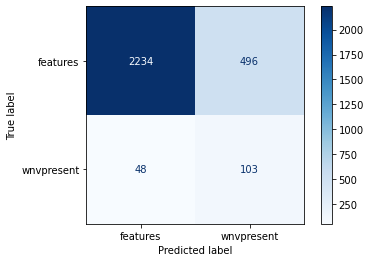

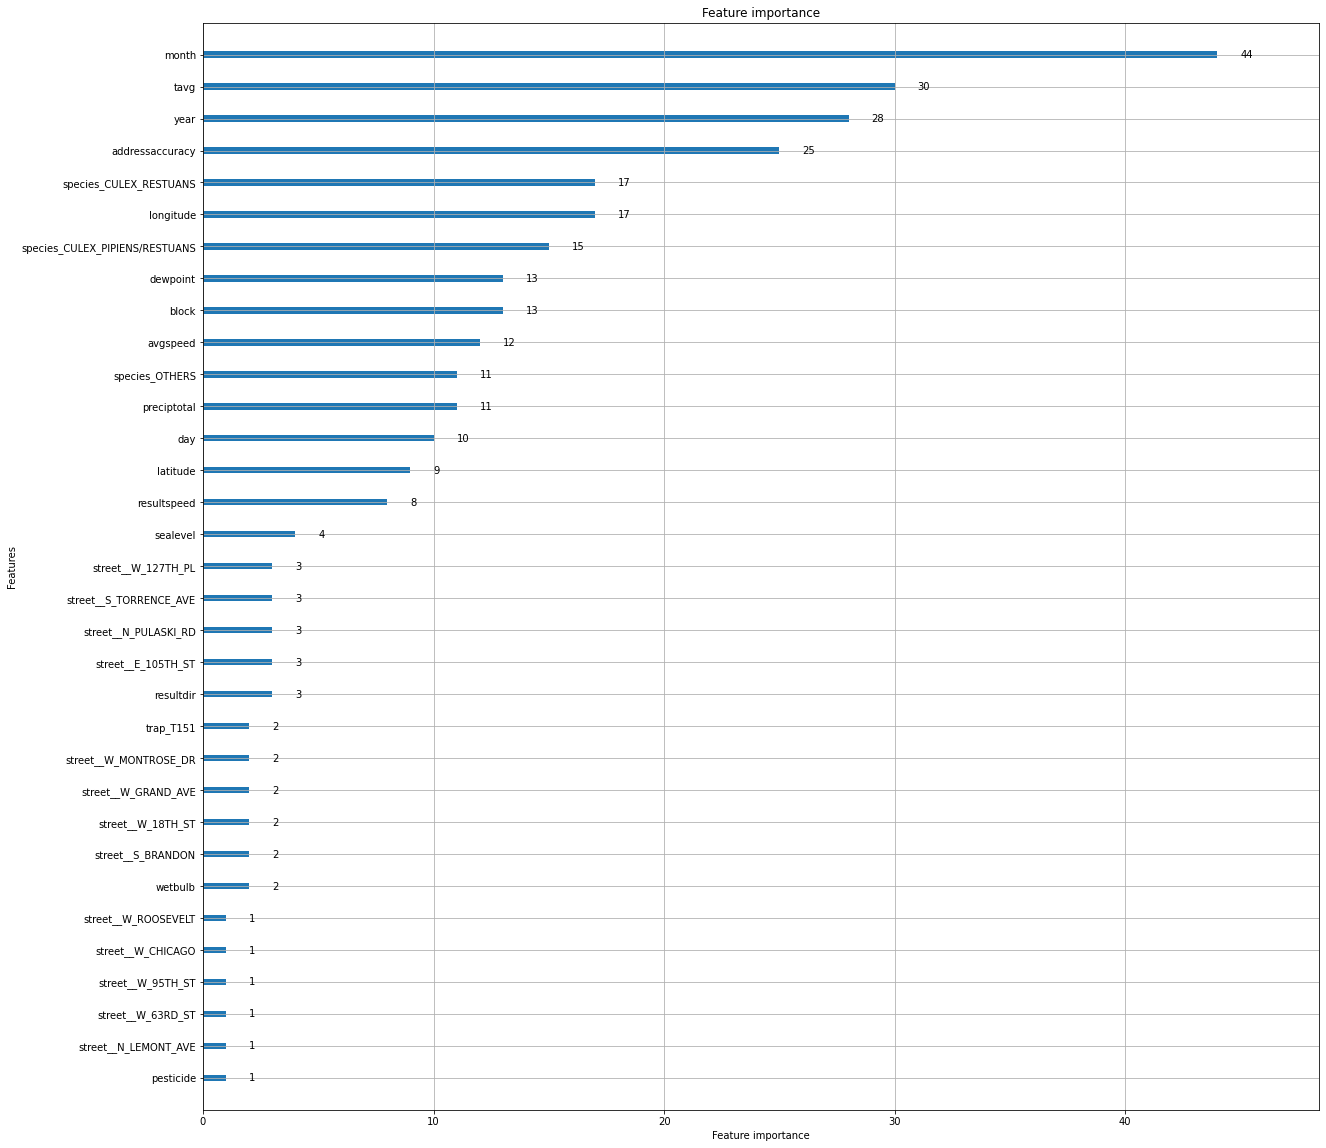

In [ ]:
# Best Model Result

pipe_param_1 = {
    'smote__k_neighbors':[5],
    'lgbm__objective':['binary'],
    'lgbm__max_depth':[None, 1, 2]
}

gscv_creator_4(model='lgbm', pipe_params_1 = pipe_param_1, resampler_1='smote', n_jobs=-1)

# Cost Benefit Analysis

The recent epidemic of the West Nile Virus in Chicago has been troubling the Department of Public Health. Though it may be impossible to fully eliminate the West Nile Virus, our goal is to curb the West Nile Virus and keep it at a controllable level for the Department of Public Health to manage. Since we know that that the West Nile Virus and the pesticides go hand in hand in keeping the West Nile Virus under control, our objective is to find the optimal level of pesticides that is to be sprayed across Chicago, while minimising the negative consequences from the utilization of the pesticides - since pesticides are a double-edged sword in the fight against the West Nile Virus.

**Costs**

There are varying costs due to the deployment of pesticides. We will look into the 3 kinds of the cost incurred: direct cost, indirect cost, and intangible cost. 

1. Direct Cost
The obvious direct cost from the deployment of pesticides is that it is expensive.
Chicago engages in Integrated Vector Management (IVM) programs that make evidence-based control decisions with information derived from well-designed surveillance systems, and that utilize a diversity of ecologically-appropriate control tools, can effectively reduce vector abundance and human West Nile Virus risk [(Source)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7092639/). Hence, with such a targeted approach, pesticides are not mindlessly sprayed across Chicago, and the expenditure on the pesticides is optimally reduced as well. In 2020, Chicago sprayed on South Lawndale, Brighton Park, Archer Heights and on the 41st Ward of Chicago [(Source)](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_communities/news/2020/august/city-to-spray-insecticide-thursday-to-kill-mosquitoes0.html). The total sprayed area is 11.4 km² + 7.045 km² +  5.206 km² + 45.014 km² = 68.665 km². Since the cost of deploying aerial spraying of common mosquito pesticides cost **USD 0.92** for half an acre, the total cost of aerial spraying on the targeted areas of Chicago would alone cost **USD 31,898.88**. Though this would kill mosquito larvae and adult mosquitoes [(Source)](https://www.cdc.gov/mosquitoes/mosquito-control/community/aerial-spraying.html), we can expect regular aerial spraying to be conducted across Chicago during the summer months and breeding season to fully keep the West Nile Virus under control. Assuming that the maximum number of sprays of 25 are conducted across Chicago on a yearly basis [(Source)](https://www.mercercounty.org/home/showdocument?id=2626#:~:text=Do%20not%20spray%20more%20than,applications%20per%20site%20per%20year.), this would cost **USD 797,472.08** for the Department of Public Health and relevant government disease control centres on the spraying of pesticides alone. This does not include the labour cost, transportation cost and others. 

2. Indirect Cost
A possible indirect cost could be the higher tax rates imposed on the residents of Chicago. The costs of the deployment of pesticides from the hired & paid workers for the spraying of the pesticides by pest control agencies, to the purchase of large quantities of pesticides, all these varying costs incurred from the deployment of the pesticides will eventually be a shared cost borne by both the state Illinois, Chicago city, and the residents of Chicago. This eventual increase in higher taxes may be a huge financial burden for the residents of Chicago who are of the lower-income category especially.

3. Intangible Cost
Notwithstanding the above, the increased taxes could lead to intangible costs such as a lower quality of life due to a higher cost of living. The slightest increase in the percentage of tax could lead to a significantly lower quality of life - especially for those in the lower-income category where every dollar counts. Even for the middle-income earners, an increase in tax could imply that one has to live more cautiously and may sacrifice non-essential expenditure like entertainment expenditure for example. 

**Benefits**

Likewise, for benefits, there are varying benefits due to the deployment of pesticides. We will look into the 4 kinds of benefits incurred: direct benefit, indirect benefit, intangible benefit, and competitive benefit (if applicable).

1. Direct Benefit
The biggest direct benefit of the use of pesticides is the decrease in people contacting the West Nile Virus. This will result in a drop in the probability of the unemployed residents in Chicago due to the being patients who contracted the West Nile Virus, or as caregivers of this patients. As a result, a steady and higher employment rate in Chicago can possibly be achieved.

2. Indirect Benefit
Additionally, the indirect benefit from the use of pesticides to curb the West Nile Virus is the potential decrease in medical costs incurred due to the West Nile Virus. Since there is no vaccine for the West Nile Virus or medication to treat patients with the West Nile Virus [(Source)](https://www.cdc.gov/westnile/index.html#:~:text=There%20are%20no%20vaccines%20to,a%20fever%20and%20other%20symptoms.), the symptoms can only be treated. For serious cases though, patients may need to be hospitalized and as such, huge hospitalization medical expenses may be incurred. Hence, the use of pesticides would significantly decrease the probability of medical expenditure due to contracting the West Nile Virus.
In 2020, the state Illinois (which Chicago is a city of) had a total of 42 patients who contracted the West Nile Virus, of which 4 patients had passed away from the virus [(Source)](https://public.dph.illinois.gov/wnvpublic/wnvglance.aspx?year=2021). Taking previous data that provided a breakdown of cost per patient in Sacramento, CA from [(Source)](https://wwwnc.cdc.gov/eid/article/16/3/09-0667_article) and use it for Chicago, this is what it would cost to be a patient with West Nile Virus Neuroinvasive Disease (WNND) [(Source)](https://pubmed.ncbi.nlm.nih.gov/16983682/):

**BASELINE**
* Outpatient cost (For all treatments) = ~USD 6,317.00
* Inpatient cost (For all treatments)=  ~USD 33,143.00
* Patient in nursing home (For all treatments) = ~USD 18,097.00
* Productivity loss (Assuming the patient is still working and below 60 years old) = ~USD 10,800.00
* Productivity loss (Assuming the patient is still working and above 60 years old) = ~USD 7,500.00

42 patients will have an equivalent of around **USD 265,000.00** if assuming all patients are outpatients or **USD 1,845,606.00** if assuming all patients are inpatients and are below 60 years old.
***(NOTE: These costs are based on Sacromento, CA cost of living so will have to scale it by 1.07 for Chicago, IL)***

3. Intangible Benefit
Intangible benefits such as improved morale and increased living satisfaction for the residents of Chicago during the summer months & West Nile Virus Season as the residents can live with greater assurance and relatively lower levels of fear of contracting the West Nile Virus. 

4. Competitive Benefit
The regular use of pesticides can give the city of Chicago a competitive edge over other cities. Chicago can stand out from her neighbouring cities and even promote herself as a choice destination for a safe summer vacation with a reduced risk of contracting the West Nile Virus. 

**Conclusion**

Comparing the costs and benefits, though it is expensive to use pesticides in the fight against the West Nile Virus, the savings and benefits that the use of pesticides bring is more than sufficient for the government to continue spending on pesticides. But more than that, we cannot put a price tag on human lives. To ensure the safety of citizens of Chicago as well a well-being of its neighboring cities from a viral pandamic like what we are experiencing right now with COVID-19 [(Source)](https://www.chicago.gov/city/en/sites/covid-19/home/covid-dashboard.html), the benefits of preventing an add-on factor on top of an ongoing pandemic will definitely outweigh the cost.


# Recommendation and Future Improvements

## Recommendations

**Focus on Education**

The government officials and the disease control centres can heavily invest resources in curbing the spread of the West Nile Virus during the summer months, which are the peak of the breeding season and spread of the virus. However, such efforts can come to a naught if the residents of Chicago do not work hand in hand with the government officials and the disease control centres. All the aerial spraying of the pesticides and the surveillance of the mosquitos will go to waste, if the residents themselves do not do their part to reduce the breeding sites of mosquitos. For example, students can be educated from a young age in schools to remove any stagnant water like the excess water on flower plates, improve drainage & remove debris on roofs and canals, and by turning water pails upside down. Furthermore, the general public can be educated on social media platforms as well. 

**Change the spray locations**

According the geopandas map that we have generated in our EDA, the presence of the West Nile Virus is relatively densely populated around the area around blocks 10, 11 and 76. There was, however, no pesticides being sprayed for those areas. Therefore, we would like to recommend pesticide to be sprayed in these areas.

**Utilize effective technologies to spray the pesticides**

Notwithstanding the above, the disease control centres can utilize drones instead of aeroplanes to spray the pesticides at a lower altitude for harder to reach targeted areas. As such, the pesticides will be sprayed more precisely at the breeding areas of the mosquitos that are carriers of the West Nile Virus.

**Consider alternative pesticides**

The main pesticides used for the West Nile Virus is Zenivex, which is an adulticide. Adulticides are however, less effective than larvicides. Hence, we would like to recommend to change the type of pesticide to the larvicide and prevent the mosquitoes that are carriers of the West Nile Virus from being hatched. 

## Further Improvements

**Continually research for less invasive solutions against the West Nile Virus**

We cannot deny that the use of pesticides, albeit an effective & necessary one, is an aggresive solution in reducing the spread of West Nile Virus. It is noted that wolbachia carrying male Aedes mosquitoes may be effective in preventing the hatching of eggs for the Aedes mosquitoes from the female Aedes mosquitoes. Though the earlier example worked in curbing the spread of Dengue by the Aedes mosquitoes, this sadly and however, does not work the same for the Culex mosquitoes of the West Nile Virus. Research has shown that when the wolbachia carrying male Culex mosquitoes were released, the West Nile Virus infection rate becomes significantly higher as compared to control. Hence, continual research should be done to optimally use wolbachia carrying male Culex mosquitoes, or use other bacterias or even genetically modify the male Culex mosquitoes to curb the spread of the West Nile Virus.

**Obtain further data to conduct on decision tree / markov models**

The problem statement has presented itself as more of an ecology problem given that the main target we are dealing with is the mosquitoes. However, the most important problem which Chicago is most likely to be interested in is the healthcare-associated costs that come from this problem since West Nile Virus has the potential to cause severe forms of diseases, such as encephalitis and meningitis, that can lead to paralysis, long term disability and coma. As such, cost-effectiveness analysis can be conducted using healthcare costs (in terms of US dollars) and quality-adjusted life years (QALY) as an indicator of effectiveness. A decision tree / markov model for economic evaluation can be drawn using the above parameters (cost and effectiveness) to calculate the incremental cost-effectiveness ratio (ICER) which can then be used to evaluate the interventions given a certain budget. This analysis takes into account which intervention is being used (in our case the intervention would be the pesticide and the control will be not using pesticide), what forms of diseases can develop in each arm, and its associated probability. At the end of the decision tree / markov model, the cost and effectiveness will be computed, combined and compared to return the ICER value. However, as of now, there is no available QALY data for West Nile Virus. Therefore, we recommend that research should be conducted to obtain these data when the intervention is being deployed so that a more robust cost-effectiveness analysis to be conducted to evaluate the use of pesticides. 

**Take into account changing environmental factors**

Changing trends in global climates have affected patterns of infectious disease transmission. Changes in weather such as increased rainfall, extreme weather events, such as flooding, and more violent heat waves have impacted patterns of insect activity and have also created environments that better suit the transmission of viruses. For example, warmer temperatures can result in a longer season yearly for mosquitoes to be active transmission vectors of WNV as they migrate within one territory or between territories, potentially increasing the spread of WNV. The WNV, first reported in Uganda in 1937, is an example of mosquito-borne viruses emerging in continents that they had never previously reached in the past 20 years. Hence, more environment-based data could be collected to conduct multi-year investigations of the complex relationship between climate change and WNV transmission for the city to adopt a multi-faceted approach for mosquito control. Other areas of improvement include investigating the development of resistance to pesticides in the mosquito populations and increasing the involvement of the public in combating and preventing a WNV outbreak.

**Referenced URLs:**

https://www.hopkinsmedicine.org/health/conditions-and-diseases/west-nile-virus#:~:text=Humans%20get%20West%20Nile%20from,to%20prevent%20West%20Nile%20virus.

https://www.indiatimes.com/technology/science-and-future/singapore-dengue-genetically-modified-mosquitoes-521477.html

https://pubmed.ncbi.nlm.nih.gov/25010200/

https://www.beyondpesticides.org/resources/mosquitos-and-insect-borne-diseases/documents/the-truth-about-mosquitoes,-pesticides-and-west-nile-virus

# Conclusion

Our analysis provides a foundation for the implementation of a statistically rigorous system for real-time forecast of seasonal WNV outbreaks and their use as a quantitative decision support tool for public health officials and mosquito control programs. We found that () () () are among the top determinants of the presence of WNV in Chicago base on the Light Gradient Boosting classifier model with a (some %?). We have presented a cross-benefit analysis of deploying pesticides to combat the WNV, concluding that the benefits would outweigh the costs of deployment. We also discussed future directions with regards to climate change and public awareness to improve Chicago's intervention programme for WNV.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=60b14a4f-b63c-4fa7-9c07-6649311f1d98' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>